# Example 2. CNN

*[Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Oleg Ovcharenko](https://ovcharenkoo.com/), 2021. "Direct domain adaptation through mutual linear transformations"*

-------
This code is modified from [https://github.com/fungtion/DANN_py3](https://github.com/fungtion/DANN_py3). 

In [1]:
import os
import sys
import random
import numpy as np

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

from components.data_loader import GetLoader
from components.model import CNNModel
from components.test import test
import components.shared as sd

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Init paths

In [3]:
# Paths to datasets
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
os.makedirs('./dataset', exist_ok=True)

# Where to save outputs
model_root = './out_ex2_cnn'
os.makedirs(model_root, exist_ok=True)

### Init training

In [4]:
cuda = True
cudnn.benchmark = True

# Hyperparameters
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

# manual_seed = random.randint(1, 10000)
manual_seed = 222
random.seed(manual_seed)
torch.manual_seed(manual_seed)
print(f'Random seed: {manual_seed}')

Random seed: 222


### Data

In [5]:
# Transformations / augmentations
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load MNIST dataset
dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

# Load MNIST-M dataset
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

# Init dataloaders
dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

### Network

Extracted from the DANN architecture defined in `ex1_dann.ipynb`

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)

        class_output = self.class_classifier(feature)
        
        # Keep the dummy output `0` for domain classifiction. Only to keep the 
        # dims of output data used in test.py
        return class_output, 0
    
#         return class_output
# from torchsummary import summary
# summary(CNNModel().cuda(), (3, 28, 28))

In [7]:
# Init network
my_net = CNNModel()

# Optimizer
optimizer = optim.Adam(my_net.parameters(), lr=lr)

# Losses
loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True

In [8]:
# Record losses for each epoch (used in compare.ipynb)
losses = {'test': {'acc_bw': [], 'acc_color': []}}
name_losses = 'losses.pkl'

### Training

Losses from previous run found!
Load dict from ./out_ex2_cnn/losses.pkl


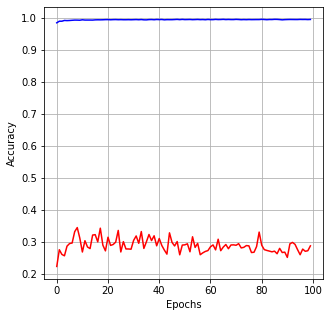

In [9]:
# training
if not name_losses in os.listdir(model_root):
# if True:
    best_accu_t = 0.0
    for epoch in range(n_epoch):

        len_dataloader = min(len(dataloader_source), len(dataloader_target))
        data_source_iter = iter(dataloader_source)
        data_target_iter = iter(dataloader_target)

        for i in range(len_dataloader):

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # training model using source data
            data_source = data_source_iter.next()
            s_img, s_label = data_source

            my_net.zero_grad()
            batch_size = len(s_label)

            if cuda:
                s_img = s_img.cuda()
                s_label = s_label.cuda()


            class_output, _ = my_net(input_data=s_img, alpha=alpha)
            err_s_label = loss_class(class_output, s_label)

            err = err_s_label
            err.backward()
            optimizer.step()

            sys.stdout.write('\r epoch: %d, [iter: %d / all %d], err_s_label: %f' \
                  % (epoch, i + 1, len_dataloader, err_s_label.data.cpu().numpy()))
            sys.stdout.flush()
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_current.pth'.format(model_root))

        print('\n')
        accu_s = test(source_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f' % ('mnist', accu_s))
        accu_t = test(target_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f\n' % ('mnist_m', accu_t))
        
        losses['test']['acc_bw'].append(accu_s)
        losses['test']['acc_color'].append(accu_t)

        if accu_t > best_accu_t:
            best_accu_s = accu_s
            best_accu_t = accu_t
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_best.pth'.format(model_root))

    print('============ Summary ============= \n')
    print('Accuracy of the %s dataset: %f' % ('mnist', best_accu_s))
    print('Accuracy of the %s dataset: %f' % ('mnist_m', best_accu_t))
    print('Corresponding model was save in ' + model_root + '/mnist_mnistm_model_epoch_best.pth')
    sd.save_dict(os.path.join(model_root, 'losses.pkl'), losses)
else:
    path_losses = os.path.join(model_root, name_losses)
    print(f'Losses from previous run found!')
    losses = sd.load_dict(path_losses)
    sd.plot_curves(losses)

In [10]:
print('============ Summary ============= \n')
print('Accuracy of the %s dataset: %f' % ('mnist', max(losses['test']['acc_bw'])))
print('Accuracy of the %s dataset: %f' % ('mnist_m', max(losses['test']['acc_color'])))
print('Corresponding model was saved into ' + model_root + '/mnist_mnistm_model_epoch_best.pth')

============ Summary ============= 

Accuracy of the mnist dataset: 0.995500
Accuracy of the mnist_m dataset: 0.343740
Corresponding model was saved into ./out_ex2_cnn/mnist_mnistm_model_epoch_best.pth
